I confess this wasn't the cleanest script to begin with. Currently modifying to count AMRs by gene instead of by plasmid to get more accurate counts.

In [1]:
import pandas as pd
import re
import seaborn as sns
from scipy import stats
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
#an important note: this only works if everything in the directory is everything you want to import.
#ChatGPT gave me a chunk of code theoretically for incorporating wildcards but it didn't work.

import subprocess

gitpath='/home/guatney/Plasmidome-of-GROWdb/'

In [2]:
def prepares_for_pairs(protocol):
    '''
    This function not only prepares a dataframe suitable for input into seaborn's pairplot function, it also creates a list
    of AMRs detected in all samples by protocol.
    Input:
        protocol (string): the protocol to fetch data from (default, conservative, or calibrated), not case sensitive
        but assumes correct spelling
    Output:
        A tuple containing:
            listofAMRs (list): a list of strings of AMR genes identified
            filteredforpairs (dataframe): a dataframe containing a subset of the metadata as well as the number of plasmids,
            plasmids/BP, AMR genes for each sample in the protocol
    
    '''
    
    protocol=protocol.lower()
    protocol_path=gitpath+'/genomad_annotations_'+protocol
    
    #count number of total AMR genes and unique AMR genes in each sample
    amrDict={}
    totalAMR=0
    amrbysample={}

    for sample in samples:
        #print(sample)
        tempfilepath=f'{protocol_path}/{sample}_B_1000_plasmid_genes.tsv'
        tempDF=pd.read_csv(tempfilepath, sep = "\t")
        sampAMR=tempDF['annotation_amr'].count()
        amrbysample[sample]=[sample, sampAMR]
        #add AMRs to dictionary
        for index, row in tempDF.iterrows():
            if not pd.isna(row['annotation_amr']):
                if sample in amrDict:
                    amrDict[sample].append(row['annotation_amr'])
                else:
                    amrDict[sample]=[row['annotation_amr']]
    
    #get list of AMRs
    listofAMRs=[]
    for sample in amrDict:
        listofAMRs.extend(amrDict[sample])
    
    #create a dataframe for use in seaborn pairs plot
    
    amrbysampledf=pd.DataFrame.from_dict(amrbysample, orient='index', columns=["SampleName","AMRgenes"])
    #amrbysampledf.head()
    
    result=pd.merge(growGS, amrbysampledf)
    
    plasmidsdict={}
    amrbysampledf=pd.DataFrame.from_dict(amrbysample, orient='index', columns=["SampleName","AMRgenes"])
    #amrbysampledf.head()
    
    result=pd.merge(growGS, amrbysampledf)

    for sample in samples:
        tempfilepath=f'{protocol_path}/{sample}_B_1000_plasmid_genes.tsv'
        tempDF=pd.read_csv(tempfilepath, sep = "\t")
        numPlasmid=tempDF.shape[0]
        plasmidPerBP=numPlasmid/growsuppdict[sample]
        plasmidsdict[sample]=[sample, numPlasmid, plasmidPerBP]
        
    plasdictdf=pd.DataFrame.from_dict(plasmidsdict, columns=["SampleName", "Plasmids", "Plasmid/BP"], orient="index")
    
    result2=pd.merge(result, plasdictdf)
    
    justwwtp=['WWTPAllDensWs', 'AMRgenes', 'Plasmids', 'Plasmid/BP', 'OmernikISite']
    
    filteredforpairs=result2[justwwtp]
    
    return (listofAMRs, filteredforpairs)

Instead of copying the entire directory structure to the GitHub to make this function work, I wrote out the list of sample names used to a text file.

In [3]:
'''
def get_samples(protocol):
    ''''''
    Take as input the filepath to the geNomad default, conservative, or calibrated putative plasmid genes
    and read all samples' putative plasmid genes.
    Input:
        protocol (string): the protocol to fetch data from (default, conservative, or calibrated), not case sensitive
        but assumes correct spelling
    Output:
        None
    ''''''
    protocol=protocol.lower()
    protocol_path='/home/chris/GROWdb/plasmids/geNomad/genomad_output_'+protocol
    samples=subprocess.check_output(['ls', protocol_path]).decode('utf-8')
    samples=samples.split("\n")
    samples=samples[:-1]
    if protocol=='default':
        samples.remove('geNomad_parallel.log')
        
    if protocol=='conservative':
        samples.remove('geNomad_conservative_parallel.log')
    if protocol=='calibrated':
        samples.remove('geNomad_calibrated_parallel.log')
        
    return samples
'''

'\ndef get_samples(protocol):\n    \n    Take as input the filepath to the geNomad default, conservative, or calibrated putative plasmid genes\n    and read all samples\' putative plasmid genes.\n    Input:\n        protocol (string): the protocol to fetch data from (default, conservative, or calibrated), not case sensitive\n        but assumes correct spelling\n    Output:\n        None\n    \n    protocol=protocol.lower()\n    protocol_path=\'/home/chris/GROWdb/plasmids/geNomad/genomad_output_\'+protocol\n    samples=subprocess.check_output([\'ls\', protocol_path]).decode(\'utf-8\')\n    samples=samples.split("\n")\n    samples=samples[:-1]\n    if protocol==\'default\':\n        samples.remove(\'geNomad_parallel.log\')\n        \n    if protocol==\'conservative\':\n        samples.remove(\'geNomad_conservative_parallel.log\')\n    if protocol==\'calibrated\':\n        samples.remove(\'geNomad_calibrated_parallel.log\')\n        \n    return samples\n'

In [4]:
#samples=get_samples('default')

In [5]:
#len(samples)

In [10]:
'''
with open('samplenames.txt', 'w') as file:
    for sample in samples:
        file.write(sample+'\n')
file.close()
'''

"\nwith open('samplenames.txt', 'w') as file:\n    for sample in samples:\n        file.write(sample+'\n')\nfile.close()\n"

In [11]:
samples=[]
with open(gitpath+'/samplenames.txt', 'r') as file:
    samples=file.read().split('\n')
file.close()

In [12]:
samples.remove('')

In [13]:
len(samples)

158

In [14]:
gispath=gitpath+'GROWdb_with_vars_20220715 (1).csv'
growGS=pd.read_csv(gispath)

In [15]:
growGS.shape

(187, 304)

In [16]:
growGS.head()

,SampleName,Sample,Date,Time,Project_PI,Location,Number_of_reads,Size_bp,3_Assemblies_done,Number_of_Bins_Medium_and_High_Quality,...,OmernikIWs,OmernikIIWs,OmernikIIIWs,source,gage_id,CFS,flow_record,percentile_20,percentile_80,flowlink
0,altamaha_2019_sw_WHONDRS-S19S_0010,S19S_0010,7/31/2019,10:14:00 AM,WHONDRS,/home/projects-wrighton-2/GROWdb/JGI_download/...,250282804.0,3.779270e+10,Y,80.0,...,EASTERN TEMPERATE FORESTS,SOUTHEASTERN USA PLAINS,Southeastern Plains,USGS (from WHONDRS),USGS-02226000,3180.000000,1980 - 2020,3030.000000,19500.00000,https://waterdata.usgs.gov/usa/nwis/dv?referre...
1,arikareeriver_2019_sw_WHONDRS-S19S_0023,S19S_0023,8/6/2019,11:38:00 AM,WHONDRS,/home/projects-wrighton-2/GROWdb/JGI_download/...,171977790.0,2.596865e+10,Y,40.0,...,GREAT PLAINS,SOUTH CENTRAL SEMIARID PRAIRIES,High Plains,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,blackearthcreek_2019_sw_WHONDRS-S19S_0061,S19S_0061,8/12/2019,9:00:00 AM,WHONDRS,/home/projects-wrighton-2/GROWdb/JGI_download/...,112929274.0,1.705232e+10,Y,21.0,...,EASTERN TEMPERATE FORESTS,MIXED WOOD PLAINS,Driftless Area,USGS (from WHONDRS),USGS-05406457,41.300000,2010 - 2020,9.796000,21.94000,https://waterdata.usgs.gov/usa/nwis/dv?referre...
3,blackwarrior_2019_sw_WHONDRS-S19S_0021,S19S_0021,8/20/2019,12:13:00 PM,WHONDRS,/home/projects-wrighton-2/GROWdb/JGI_download/...,98893064.0,1.493285e+10,Y,63.0,...,EASTERN TEMPERATE FORESTS,OZARK/OUACHITA-APPALACHIAN FORESTS,Southwestern Appalachians,NEON (from WHONDRS),NEON-BLWA,2402.954791,2018 - 2020,1967.600546,24003.84798,https://data.neonscience.org/home
4,blueriver_2019_sw_WHONDRS-S19S_0024,S19S_0024,8/18/2019,12:40:00 PM,WHONDRS,/home/projects-wrighton-2/GROWdb/JGI_download/...,210080280.0,3.172212e+10,Y,82.0,...,GREAT PLAINS,SOUTH CENTRAL SEMIARID PRAIRIES,Cross Timbers,USGS (from WHONDRS),USGS-07332390,68.100000,2004 - 2020,35.700000,146.00000,https://waterdata.usgs.gov/usa/nwis/dv?referre...


In [17]:
filtered_GROW = growGS.loc[growGS['SampleName'].isin(samples)]
#filtered_GROW.sort_values(by="SampleName")

#list(filtered_GROW['SampleName'])


### Duplicated GROW GIS metadata row, a post-thesis side quest

Noticed that shape of filtered_GROW was slightly different:

In [18]:
filtered_GROW.shape

(159, 304)

Found the duplicated row:

In [19]:
filtered_GROW[filtered_GROW['SampleName'].duplicated()]

,SampleName,Sample,Date,Time,Project_PI,Location,Number_of_reads,Size_bp,3_Assemblies_done,Number_of_Bins_Medium_and_High_Quality,...,OmernikIWs,OmernikIIWs,OmernikIIIWs,source,gage_id,CFS,flow_record,percentile_20,percentile_80,flowlink
149,NASQAN2015_042,NASQAN2015_042,7/27/2015,10:30:00 AM,Byron,/home/projects-wrighton-2/GROWdb/Byron_data/NA...,141929584.0,2.143137e+10,Y,12.0,...,NORTHWESTERN FORESTED MOUNTAINS,WESTERN CORDILLERA,"California Coastal Sage, Chaparral, and Oak Wo...",USGS,USGS-11447650,7794.104167,2008 - 2021,9405.895833,21837.91667,https://waterdata.usgs.gov/usa/nwis/uv?referre...


In [20]:
nasqan2015_42=filtered_GROW[filtered_GROW['SampleName']=='NASQAN2015_042']
nasqan2015_42

,SampleName,Sample,Date,Time,Project_PI,Location,Number_of_reads,Size_bp,3_Assemblies_done,Number_of_Bins_Medium_and_High_Quality,...,OmernikIWs,OmernikIIWs,OmernikIIIWs,source,gage_id,CFS,flow_record,percentile_20,percentile_80,flowlink
148,NASQAN2015_042,NASQAN2015_042,7/27/2015,10:30:00 AM,Byron,/home/projects-wrighton-2/GROWdb/Byron_data/NA...,141929584.0,2.143137e+10,Y,12.0,...,NORTHWESTERN FORESTED MOUNTAINS,WESTERN CORDILLERA,"California Coastal Sage, Chaparral, and Oak Wo...",USGS,USGS-11447650,8050.000000,1980 - 2015,10700.000000,28500.00000,https://waterdata.usgs.gov/usa/nwis/dv?referre...
149,NASQAN2015_042,NASQAN2015_042,7/27/2015,10:30:00 AM,Byron,/home/projects-wrighton-2/GROWdb/Byron_data/NA...,141929584.0,2.143137e+10,Y,12.0,...,NORTHWESTERN FORESTED MOUNTAINS,WESTERN CORDILLERA,"California Coastal Sage, Chaparral, and Oak Wo...",USGS,USGS-11447650,7794.104167,2008 - 2021,9405.895833,21837.91667,https://waterdata.usgs.gov/usa/nwis/uv?referre...


Decided to drop the row containing the older data (as evidenced by column 'flow_record'), though there isn't much difference between them.

In [21]:
set148=set(filtered_GROW[filtered_GROW['SampleName']=='NASQAN2015_042'].loc[148])
set149=set(filtered_GROW[filtered_GROW['SampleName']=='NASQAN2015_042'].loc[149])
set148.difference(set149)

{10700.0,
 '1980 - 2015',
 28500.0,
 8050.0,
 'https://waterdata.usgs.gov/usa/nwis/dv?referred_module=sw&site_no=11447650',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan}

In [22]:
filtered_GROW=filtered_GROW.drop(148)

In [23]:
filtered_GROW.shape

(158, 304)

### Import sequencing data for plasmids/megabase

In [24]:
#import sequencing effort data
supppath=gitpath+'GROW_SuppFile1_Sequencing.csv'
growsupp=pd.read_csv(supppath)
growsupp.set_index('SampleName', inplace=True)
growsuppdict=growsupp['MetaG Size_bp'].to_dict()

In [25]:
growsupp

,Sample,Date,Project,contributing PI,MetaG Number_of_reads,MetaG Size_bp,Number_of_Bins_Medium_and_High_Quality,Country,GROW_version,has_MetaT,MetaT_bp,has_FTICR,Latitude,Longitude,MetaG_JGI_accession,MetaT sequencing location,MetaT_accession,MetaG mapping,Removed from mapping analysis
SampleName,,,,,,,,,,,,,,,,,,,
augustacreek_2019_sw_WHONDRS-S19S_0067,S19S_0067,8/12/19,WHONDRS,James Stegen,NaN,NaN,NaN,USA,v1,Y,1.802216e+10,Y,42.392100,-85.354120,NaN,JGI,3300042578,NaN,NaN
cachelapoudre_2019_sw_WHONDRS-S19S_0077,S19S_0077,8/18/19,WHONDRS,James Stegen,NaN,NaN,NaN,USA,v1,Y,1.005242e+10,Y,40.664030,-105.223141,NaN,UC Denver,TBD,NaN,NaN
cartcreek_2019_sw_WHONDRS-S19S_0073,S19S_0073,8/12/19,WHONDRS,James Stegen,NaN,NaN,NaN,USA,v1,Y,1.070084e+10,Y,42.768806,-70.916499,NaN,UC Denver,TBD,NaN,NaN
kingscreed_2019_sw_WHONDRS-S19S_0040,S19S_0040,8/5/19,WHONDRS,James Stegen,NaN,NaN,NaN,USA,v1,Y,8.300571e+09,Y,39.087889,-96.584725,NaN,UC Denver,TBD,NaN,NaN
sawmillbrook_2019_sw_WHONDRS-S19S_0072,S19S_0072,8/12/19,WHONDRS,James Stegen,NaN,NaN,NaN,USA,v1,Y,8.766472e+09,Y,42.523564,-71.184820,NaN,UC Denver,TBD,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NASQAN2011_277,NASQAN2011_277,3/7/11,NASQAN,Byron Crump,53486686.0,8.076490e+09,0.0,USA,v1,N,NaN,N,41.780590,-90.252070,3.300047e+09,NaN,NaN,0.00000,Yes
NASQAN2011_229,NASQAN2011_229,8/25/11,NASQAN,Byron Crump,43763328.0,6.608263e+09,0.0,USA,v1,N,NaN,N,30.690740,-91.736230,3.300047e+09,NaN,NaN,0.00000,Yes
NASQAN2011_034,NASQAN2011_034,2/8/11,NASQAN,Byron Crump,41147108.0,6.213213e+09,0.0,USA,v1,N,NaN,N,38.130880,-87.941420,3.300047e+09,NaN,NaN,0.00000,Yes


### Default geNomad

In [26]:
#default geNomad import
#samples=get_samples('default')

In [27]:
listofAMRs, forpairs=prepares_for_pairs('default')

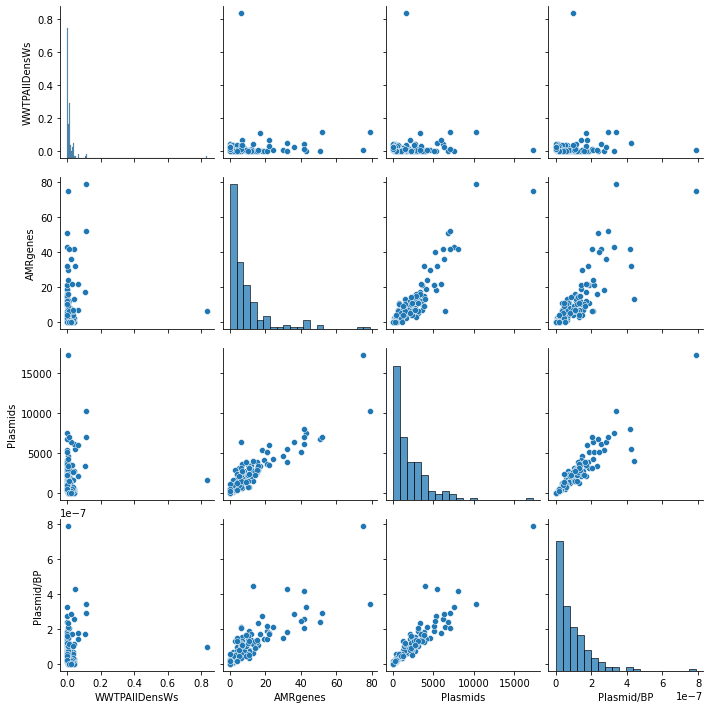

In [28]:
plt=sns.pairplot(forpairs)

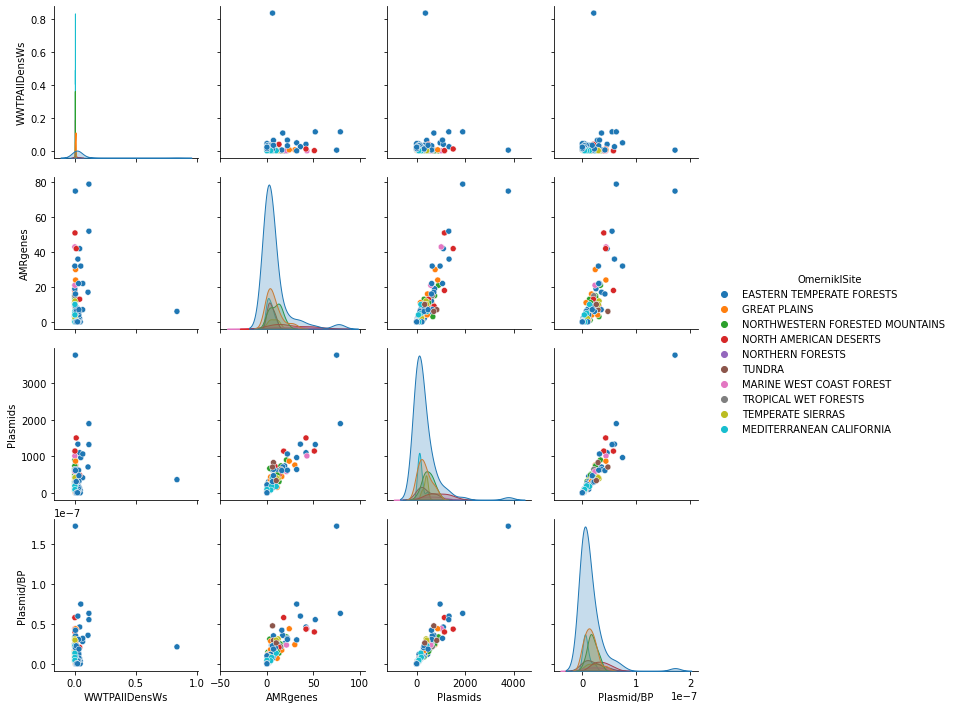

In [20]:
#this was an exploratory figure that looks very cool and is not very interesting
plt=sns.pairplot(forpairs, hue='OmernikISite')
#plt.subtitle("Correlations Between Density of Wastewater Treatment Plants in Watershed with\n Number of AMR Genes, Plasmids, and Plasmids per BP in Sample")

In [54]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['Plasmids']),nan_policy="omit")

SpearmanrResult(correlation=-0.26312823831557847, pvalue=0.0023016773149834597)

In [55]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['AMRgenes']),nan_policy="omit")

SpearmanrResult(correlation=-0.2134578642928508, pvalue=0.013990330640447635)

In [56]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['Plasmid/BP']),nan_policy="omit")

SpearmanrResult(correlation=-0.2236952419838782, pvalue=0.00992653006049658)

In [64]:
countAMRs=Counter(listofAMRs)
len(countAMRs)

58

### Calibrated geNomad

In [65]:
calilistofAMRs, forpairs=prepares_for_pairs('calibrated')

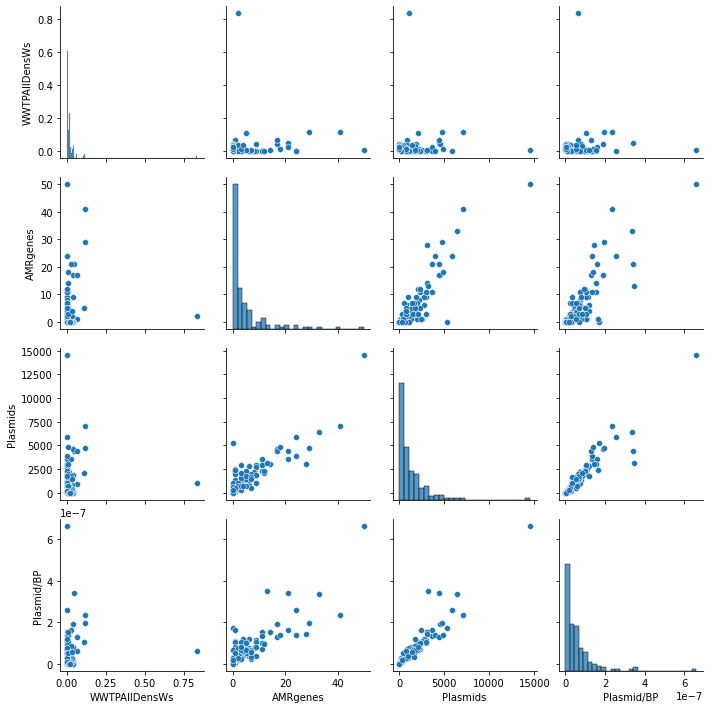

In [66]:
pltcali=sns.pairplot(forpairs)

In [67]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['Plasmids']),nan_policy="omit")

SpearmanrResult(correlation=-0.27126942339365523, pvalue=0.0016539721161025042)

In [68]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['AMRgenes']),nan_policy="omit")

SpearmanrResult(correlation=-0.22936683556733595, pvalue=0.00815638061033582)

In [69]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['Plasmid/BP']),nan_policy="omit")

SpearmanrResult(correlation=-0.23931313575149277, pvalue=0.005716337551794554)

In [70]:
countAMRs=Counter(calilistofAMRs)

In [71]:
countAMRs

Counter({'NF000496': 83,
         'NF033156': 3,
         'NF033144': 1,
         'NF033105': 56,
         'NF033087': 29,
         'NF033145': 23,
         'NF012147': 12,
         'NF012174': 75,
         'NF000138': 3,
         'NF033135': 63,
         'NF033117': 35,
         'NF000402': 43,
         'NF000272': 66,
         'NF033088': 10,
         'NF033068': 25,
         'NF012212': 5,
         'NF033476': 28,
         'NF033083': 3,
         'NF000025': 10,
         'NF000373': 3,
         'NF033134': 5,
         'NF012178': 18,
         'NF000091': 3,
         'NF000005': 6,
         'NF000493': 7,
         'NF000027': 5,
         'NF033103': 4,
         'NF000270': 1,
         'NF040806': 9,
         'NF000052': 6,
         'NF000469': 3,
         'NF033085': 2,
         'NF012171': 7,
         'NF033129': 3,
         'NF000088': 7,
         'NF000456': 4,
         'NF033075': 2,
         'NF000246': 1,
         'NF000095': 5,
         'NF000125': 2,
         'NF012176': 1,
 

In [72]:
len(countAMRs)

49

In [73]:
sum(countAMRs.values())

689

In [74]:
#get top quarter of AMRs
def get_top_quarter(counter):
    # Sort the counter items by their counts in descending order
    sorted_items = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    
    # Determine the index to split the items into top and bottom halves
    split_index = len(sorted_items) // 2
    
    # Create a new Counter for the top half
    top_half = sorted_items[:split_index]
    
    return top_half

In [75]:
topquarterAMRs=get_top_quarter(countAMRs)

In [76]:
topquarterAMRs

[('NF000496', 83),
 ('NF012174', 75),
 ('NF000272', 66),
 ('NF033135', 63),
 ('NF033105', 56),
 ('NF000402', 43),
 ('NF033117', 35),
 ('NF033087', 29),
 ('NF033476', 28),
 ('NF033068', 25),
 ('NF033145', 23),
 ('NF012178', 18),
 ('NF012147', 12),
 ('NF033088', 10),
 ('NF000025', 10),
 ('NF040806', 9),
 ('NF000493', 7),
 ('NF012171', 7),
 ('NF000088', 7),
 ('NF000005', 6),
 ('NF000052', 6),
 ('NF012212', 5),
 ('NF033134', 5),
 ('NF000027', 5)]

In [77]:
amrs=[amrtuple[0] for amrtuple in topquarterAMRs]
counts=[amrtuple[1] for amrtuple in topquarterAMRs]

In [36]:
# from external searching

more_info_xticks=[
    'multidrug efflux RND transporter periplasmic adaptor subunit OqxA',
    'Cmx/CmrA family chloramphenicol efflux MFS transporter',
    'Tet(A)/Tet(B)/Tet(C) family tetracycline efflux MFS transporter',
    'fosfomycin resistance glutathione transferase',
    'subclass B3 metallo-beta-lactamase',
    'vancomycin resistance response regulator transcription factor VanR-B',
    'VanR-ABDEGLN family response regulator transcription factor',
    'APH(3\') family aminoglycoside O-phosphotransferase',
    'tetracycline efflux MFS transporter Tet(V)',
    'tetracycline destructase',
    'IMP family subclass B1 metallo-beta-lactamase',
    'rifampin monooxygenase',
    'subclass B2 metallo-beta-lactamase',
    'tetracenomycin C efflux MFS transporter',
    'OXA-198 family carbapenem-hydrolyzing class D beta-lactamase',
    'subclass B1 metallo-beta-lactamase',
    'FosB/FosD family fosfomycin resistance bacillithiol transferase',
    'BLMT family bleomycin binding protein',
    'viomycin phosphotransferase',
    'tetracycline destructase; subclass B2 metallo-beta-lactamase',
    'CmlA/FloR family chloramphenicol efflux MFS transporter',
    'bleomycin binding protein',
]

In [37]:
len(more_info_xticks)

22

In [78]:
len(counts)

24

In [66]:
counts=np.array(counts)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

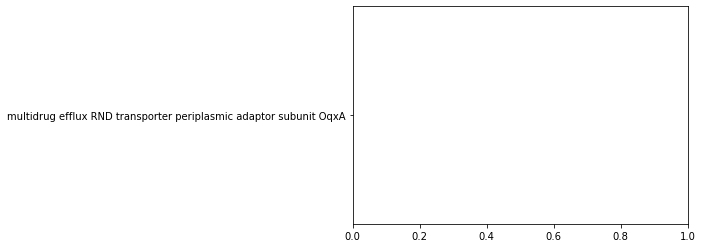

In [67]:
plt.barh(width=counts, y=more_info_xticks)
#plt.xticks(rotation=90)
#plt.title('Occurrence of Top Quartile of Antimicrobial Resistance \n Genes in Calibrated geNomad')
#plt.ylabel('Counts')

### Conservative geNomad

In [41]:
conslistofAMRs, forpairs=prepares_for_pairs('conservative')

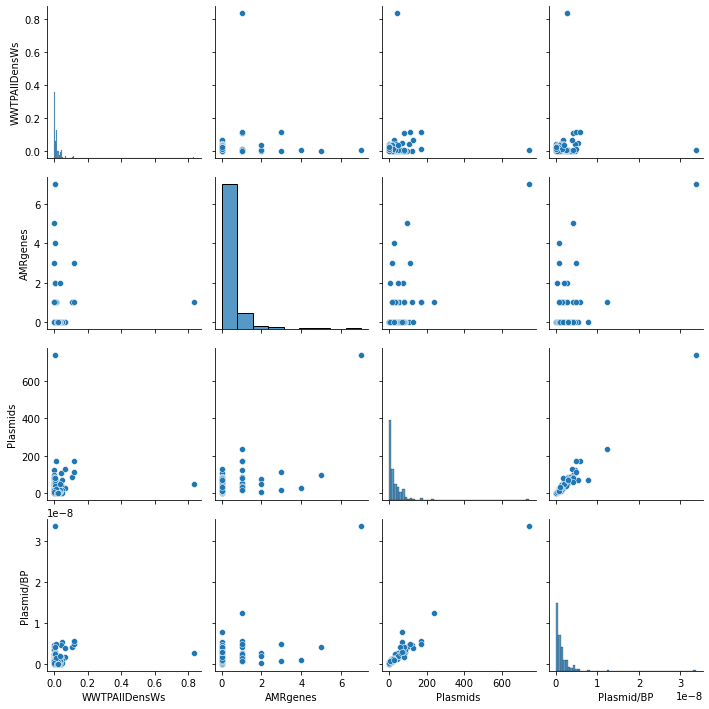

In [42]:
consplt=sns.pairplot(forpairs)

In [43]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['Plasmids']),nan_policy="omit")

SpearmanrResult(correlation=-0.22872715571539382, pvalue=0.00834097329073077)

In [44]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['AMRgenes']),nan_policy="omit")

SpearmanrResult(correlation=-0.1523757456175594, pvalue=0.08112188232641439)

In [45]:
stats.spearmanr(np.array(forpairs['WWTPAllDensWs']), np.array(forpairs['Plasmid/BP']),nan_policy="omit")

SpearmanrResult(correlation=-0.1805756120114144, pvalue=0.038266532832523306)

In [50]:
countAMRs=Counter(calilistofAMRs)

In [51]:
len(countAMRs)

49

In [52]:
sortedAMRs=countAMRs.most_common()
sortAMRcounts=[]
for item, count in sortedAMRs:
    sortAMRcounts.append(count)
    print(f"{item}: {count}")

NF000496: 83
NF012174: 75
NF000272: 66
NF033135: 63
NF033105: 56
NF000402: 43
NF033117: 35
NF033087: 29
NF033476: 28
NF033068: 25
NF033145: 23
NF012178: 18
NF012147: 12
NF033088: 10
NF000025: 10
NF040806: 9
NF000493: 7
NF012171: 7
NF000088: 7
NF000005: 6
NF000052: 6
NF012212: 5
NF033134: 5
NF000027: 5
NF000095: 5
NF033103: 4
NF000456: 4
NF033156: 3
NF000138: 3
NF033083: 3
NF000373: 3
NF000091: 3
NF000469: 3
NF033129: 3
NF033085: 2
NF033075: 2
NF000125: 2
NF033115: 2
NF000241: 2
NF033114: 2
NF000406: 2
NF033144: 1
NF000270: 1
NF000246: 1
NF012176: 1
NF000482: 1
NF033693: 1
NF000034: 1
NF012229: 1


In [46]:
growsupp=pd.read_csv("/home/guatney/plasmidome/GROW_SuppFile1_Sequencing.csv")
growsupp.set_index('SampleName', inplace=True)
growsuppdict=growsupp['MetaG Size_bp'].to_dict()

In [47]:
#get number of AMRs per sample
plasmidsdict={}

for sample in samples:
    tempfilepath=f'/home/guatney/plasmidome/genomad_calibrated/{sample}_B_1000_plasmid_summary.tsv'
    tempDF=pd.read_csv(tempfilepath, sep = "\t")
    numPlasmid=tempDF.shape[0]
    plasmidPerBP=numPlasmid/growsuppdict[sample]
    plasmidsdict[sample]=[sample, numPlasmid, plasmidPerBP]

In [48]:
amrbysampledf=pd.DataFrame.from_dict(amrbysample, orient='index', columns=["SampleName","AMRgenes"])
amrbysampledf.head()

NameError: name 'amrbysample' is not defined

In [62]:
#may consider going back to change var names here
result=pd.merge(growGS, amrbysampledf, how= 'right')

In [63]:
plasmidsdictdf=pd.DataFrame.from_dict(plasmidsdict, columns=["SampleName", "Plasmids", "Plasmid/BP"], orient="index")

In [64]:
#amrbysampledf=pd.DataFrame.from_dict(amrbysample, orient='index', columns=["SampleName","AMRgenes"])
#growGS.set_index('SampleName', inplace=True)
#result=pd.merge(growGS, amrbysampledf)
result2=pd.merge(result, plasmidsdictdf, how="outer")

In [65]:
result2.columns

Index(['SampleName', 'Sample', 'Date', 'Time', 'Project_PI', 'Location',
       'Number_of_reads', 'Size_bp', '3_Assemblies_done',
       'Number_of_Bins_Medium_and_High_Quality',
       ...
       'source', 'gage_id', 'CFS', 'flow_record', 'percentile_20',
       'percentile_80', 'flowlink', 'AMRgenes', 'Plasmids', 'Plasmid/BP'],
      dtype='object', length=307)

In [66]:
justwwtp=['WWTPAllDensWs', 'AMRgenes', 'Plasmids', 'Plasmid/BP', 'OmernikISite']
forpairs=result2[justwwtp]

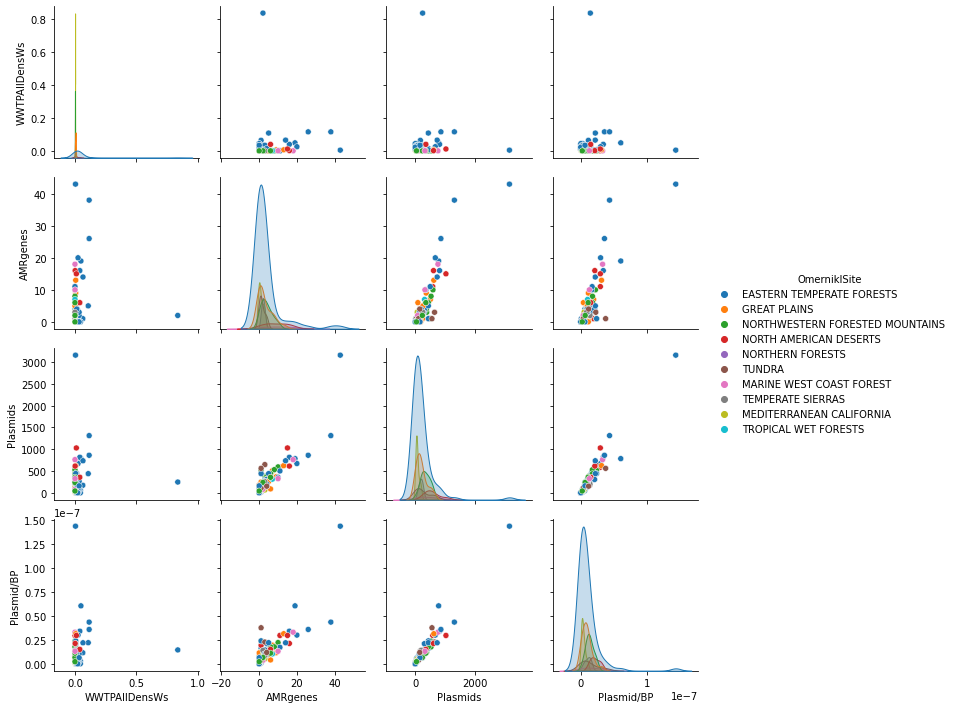

In [67]:
import seaborn as sns

sns.pairplot(forpairs, hue='OmernikISite')

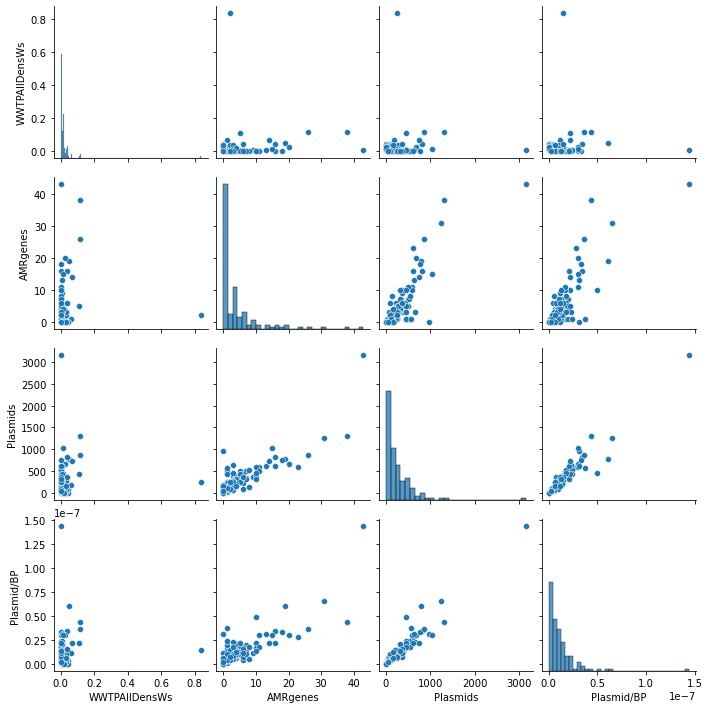

In [68]:
sns.pairplot(forpairs)

### Next time we will add conservative from where I've just left off

Consider making a function so that you look less like an idiot

In [ ]:
amrDict

In [ ]:
totalAMR

In [ ]:
amrDict

In [70]:
pd.concat(growGS, pd.DataFrame(amrDict))

ValueError: All arrays must be of the same length

In [ ]:
len(list(filtered_GROW['SampleName']))

In [68]:
listofAMRs=[]
for sample in amrDict:
    listofAMRs.extend(amrDict[sample])
listofAMRs

['NF000496',
 'NF033144',
 'NF033105',
 'NF033156',
 'NF012147',
 'NF000138',
 'NF033087',
 'NF000138',
 'NF033135',
 'NF033087;NF033145;NF000496',
 'NF012174',
 'NF033117',
 'NF033105',
 'NF000402',
 'NF000272',
 'NF000272',
 'NF033105',
 'NF012174;NF012174;NF033145',
 'NF033088',
 'NF012174',
 'NF033068',
 'NF033135',
 'NF012174',
 'NF033135',
 'NF000272',
 'NF033145',
 'NF033117',
 'NF033105',
 'NF033135',
 'NF012212',
 'NF000402',
 'NF000272',
 'NF000272',
 'NF012147',
 'NF033476',
 'NF000272',
 'NF000272',
 'NF000272',
 'NF033083',
 'NF012147',
 'NF012174',
 'NF000272',
 'NF012147',
 'NF012174',
 'NF000402',
 'NF033117',
 'NF033087;NF033476',
 'NF033083',
 'NF000025',
 'NF033068',
 'NF012147',
 'NF012174',
 'NF033105',
 'NF012174',
 'NF033087;NF033476;NF000496',
 'NF012174',
 'NF033476;NF033088',
 'NF033105',
 'NF033145',
 'NF033476;NF033087',
 'NF033135',
 'NF033476',
 'NF000373',
 'NF000496',
 'NF000272',
 'NF012174',
 'NF000272',
 'NF033068',
 'NF033135',
 'NF012174',
 'NF00049

In [27]:
from collections import Counter
countAMRs=Counter(listofAMRs)
#countAMRs

In [42]:
sortedAMRs=countAMRs.most_common()
sortAMRcounts=[]
for item, count in sortedAMRs:
    sortAMRcounts.append(count)
    print(f"{item}: {count}")

NF012174: 8
NF000496: 8
NF033135: 5
NF033117: 4
NF033145: 4
NF033105: 3
NF000272: 2
NF000402: 2
NF033068: 2
NF033087: 1
NF000095: 1
NF033129: 1
NF000241: 1
NF033476: 1


In [37]:
reversesortAMRcounts=[]
reversesortAMRvalues=[]
for pair in sortedAMRs:
    reversesortAMRvalues.append(pair[0])
    reversesortAMRcounts.append(pair[1])
reversesortAMRvalues

['NF012174',
 'NF000496',
 'NF033135',
 'NF033117',
 'NF033145',
 'NF033105',
 'NF000272',
 'NF000402',
 'NF033068',
 'NF033087',
 'NF000095',
 'NF033129',
 'NF000241',
 'NF033476']

In [ ]:
moreinformativexlabels=['Tet(A)/Tet(B)/Tet(C) family tetracycline efflux MFS transporter',
                        'fosfomycin resistance glutathione transferase',
                        'Cmx/CmrA family chloramphenicol efflux MFS transporter',
                        'VanR-ABDEGLN family response regulator transcription factor',
                        'rifampin monooxygenase',
                        'subclass B3 metallo-beta-lactamase',
                        'multidrug efflux RND transporter periplasmic adaptor subunit OqxA',
                        'vancomycin resistance response regulator transcription factor VanR-B',
                        'APH(3\') family aminoglycoside O-phosphotransferase',
                        'subclass B2 metallo-beta-lactamase',
                        'oxytetracycline resistance efflux MFS transporter OtrB',
                        'macrolide-inactivating glycosyltransferase',
                        'Mph(E)/Mph(G) family macrolide 2\'-phosphotransferase',
                        'tetracycline destructase'
                       ]

In [ ]:
moreinformativexlabels.reverse()

In [ ]:
import matplotlib.pyplot as plt

plt.barh(moreinformativexlabels.reverse(), sortAMRcounts)
plt.xticks(rotation=90)
plt.title('Occurrence of All Antimicrobial Resistance Genes in Conservative geNomad')
#plt.ylabel('Counts')

In [29]:
'''
moreinformativexlabels=['Mph(E)/Mph(G) family macrolide 2\'-phosphotransferase',
                        'Tet(A)/Tet(B)/Tet(C) family tetracycline efflux MFS transporter',
                        'fosfomycin resistance glutathione transferase',
                        'APH(3\') family aminoglycoside O-phosphotransferase',
                        'VanR-ABDEGLN family response regulator transcription factor',
                        'multidrug efflux RND transporter periplasmic adaptor subunit OqxA',
                        'rifampin monooxygenase',
                        'subclass B3 metallo-beta-lactamase',
                        'Cmx/CmrA family chloramphenicol efflux MFS transporter',
                        'subclass B2 metallo-beta-lactamase',
                        'vancomycin resistance response regulator transcription factor VanR-B',
                        'oxytetracycline resistance efflux MFS transporter OtrB',
                        'macrolide-inactivating glycosyltransferase',
                        'tetracycline destructase'
                       ]
'''

Text(0.5, 1.0, 'Occurrence of All Antimicrobial Resistance Genes in Conservative geNomad')

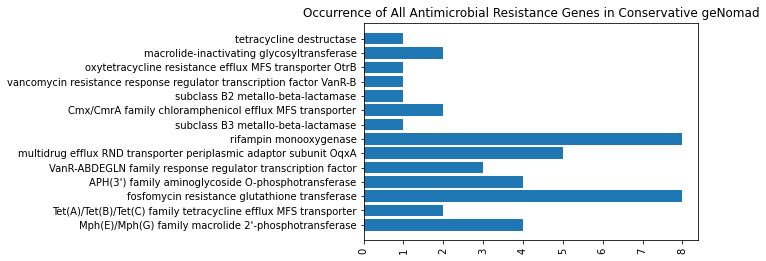

In [30]:
'''
import matplotlib.pyplot as plt

plt.barh(moreinformativexlabels, list(countAMRs.values()),)
plt.xticks(rotation=90)
plt.title('Occurrence of All Antimicrobial Resistance Genes in Conservative geNomad')
#plt.ylabel('Counts')
'''